# Newtork Regularization

___

*Source: [Chollet et al., Deep Learning With R](https://www.amazon.com/Deep-Learning-R-Francois-Chollet/dp/161729554X) *

___

In all the examples in the previous chapter—predicting movie reviews, topic classification, and house-price regression—the performance of the model on the held-out validation data always peaked after a few epochs and then began to degrade: that is, the model quickly started to **overfit** to the training data. 

In [1]:
source('src/lib.R')

Overfitting happens in every machine learning problem (as we have seen). Learning how to deal with it is essential!

The fundamental issue in machine learning is the **trade-off between optimization and generalization**.
Optimization refers to the process of adjusting a model to get the best performance possible on the training data (the learning machine learning ), whereas 
generalization refers to how well the trained model performs on data it has never seen before.
The goal of the game is to get good generalization, of course, but you don’t
control generalization; you can only adjust the model based on its training data.

Always keep this in mind: deep-learning models tend to be good at fitting to the training data, but the real challenge is
generalization, not fitting.

> The process of fighting overfitting is called **regularization**.

In [2]:
mnist = dataset_mnist()

c(c(train_images, train_labels), c(test_images, test_labels)) %<-% mnist

train_images = array_reshape(train_images, c(60000, 28 * 28)) / 255
test_images = array_reshape(test_images, c(10000, 28 * 28)) / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

## A short overfitting tale
1. At the beginning of training, optimization and generalization are correlated: the lower the loss on training data, the lower the loss on test data. While this is happening, your model is said to be under-fit : there is still progress to be made; the network hasn’t yet modeled all relevant patterns in the training data.
2. After a certain number of iterations on the training data, generalization stops improving, and validation metrics stall and then begin to degrade: the model is starting to over-fit. That is, it’s beginning to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to
new data.
3. End.

## How to deal with overfitting issues
### Reducing the network's size
The simplest way to prevent overfitting is to **reduce the capacity** (i.e. the size) of the model: that is, the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). Intuitively, a model with more parameters has more memorization capacity and therefore can easily learn a perfect dictionary-like mapping between training samples and their targets—a mapping without any generalization power.

On the other hand, if the network has limited memorization resources, it won’t be able to learn this mapping as easily; thus, in order to minimize its loss, **the model will have to resort to learning compressed representations that have predictive power regarding the targets** precisely the type of representations we’re interested in.

At the same time, keep in mind that you should use models that have enough parameters that they don’t underfit: your model shouldn’t be starved for memorization resources. There is a compromise to be found between too much capacity and not enough capacity.

In [3]:
(model_large = keras_model_sequential() %>% 
            layer_dense(units = 512, activation = "relu",
                        input_shape = c(28 * 28), use_bias = T, name='first_layer') %>%
            layer_dense(units = 10, activation = "softmax",
                        use_bias = T, name = 'output_layer'))

(model_small = keras_model_sequential() %>% 
            layer_dense(units = 128, activation = "relu",
                        input_shape = c(28 * 28), use_bias = T, name='first_layer') %>%
            layer_dense(units = 10, activation = "softmax",
                        use_bias = T, name = 'output_layer'))

model_large %>% compile(optimizer = "rmsprop",
                    loss = "categorical_crossentropy",
                    metrics = c("accuracy")
                    )

model_small %>% compile(optimizer = "rmsprop",
                    loss = "categorical_crossentropy",
                    metrics = c("accuracy")
                    )

model_large %>% fit(train_images,
                train_labels,
                epochs = 40,
                batch_size = 128,
                validation_split = 0.2
                ) -> history_large

model_small %>% fit(train_images,
                train_labels,
                epochs = 40,
                batch_size = 128,
                validation_split = 0.2
                ) -> history_small

model_large$save('data/model_large.h5')
model_large$save_weights('data/model_large_w.h5')
saveRDS(history_large, 'data/history_large.rds')

model_small$save('data/model_small.h5')
model_small$save_weights('data/model_small_w.h5')
saveRDS(history_small, 'data/history_small.rds')

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
first_layer (Dense)                 (None, 512)                     401920      
________________________________________________________________________________
output_layer (Dense)                (None, 10)                      5130        
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
________________________________________________________________________________



Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
first_layer (Dense)                 (None, 128)                     100480      
________________________________________________________________________________
output_layer (Dense)                (None, 10)                      1290        
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
________________________________________________________________________________



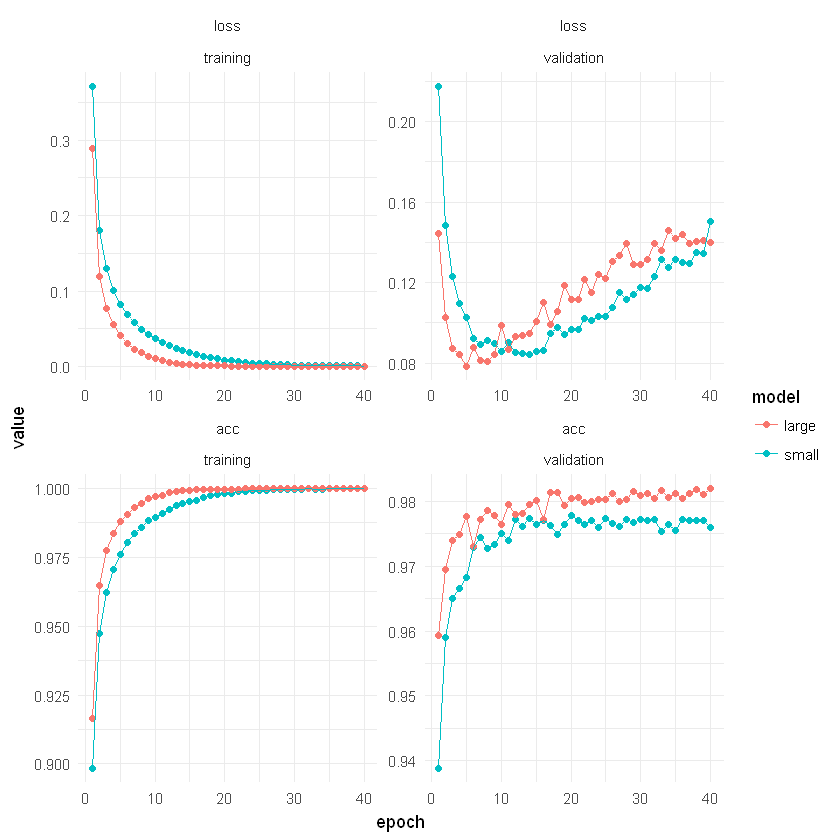

In [4]:
history_small = history_small %>% as_data_frame %>% mutate(model = 'small')
history_large = history_large  %>% as_data_frame %>% mutate(model = 'large')

history_bind = bind_rows(history_small, history_large)

history_bind %>% ggplot(aes(x = epoch, y = value, group = model, colour = model)) +
    geom_point() +
    geom_line() +
    facet_wrap(scales = 'free', ~metric+data, ncol = 2) + theme_minimal()

### Adding weight regularization

You may be familiar with the principle of Occam’s razor : given two explanations for something, the explanation most likely to be correct is the simplest one—the one that makes fewer assumptions. This idea also applies to the models learned by neural networks: given some training data and a network architecture, multiple sets of weight values (multiple models ) could explain the data. Simpler models are less likely to overfit than complex ones. A
simple model in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters, as you saw in the previous section). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to take only small values, which makes the distribution of weight values more
regular . This is called weight regularization , and it’s done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

- **L1 regularization** The cost added is proportional to the absolute value of the weight (the coefficients L1 norm L2 regularization—The cost added is proportional to the square of the value of the (the of the weights). weight coefficients L2 norm of the weights).
- **L2 regularization** is also called weight decay in the context of neural networks. Don’t let the different name confuse you: weight decay is mathematically the same as L2 regularization.

In [5]:
(model_large_regularized = keras_model_sequential() %>% 
            layer_dense(units = 512, activation = "relu",
                        input_shape = c(28 * 28), use_bias = T, name='first_layer',
                        kernel_regularizer = regularizer_l2(0.0001)
                       ) %>%
            layer_dense(units = 10, activation = "softmax",
                        use_bias = T, name = 'output_layer',
                        kernel_regularizer = regularizer_l2(0.0001)
                       ))

(model_small_regularized = keras_model_sequential() %>% 
            layer_dense(units = 128, activation = "relu",
                        input_shape = c(28 * 28), use_bias = T, name='first_layer',
                        kernel_regularizer = regularizer_l2(0.0001)) %>%
            layer_dense(units = 10, activation = "softmax",
                        use_bias = T, name = 'output_layer',
                        kernel_regularizer = regularizer_l2(0.0001)
                       ))

model_large_regularized %>% compile(optimizer = "rmsprop",
                    loss = "categorical_crossentropy",
                    metrics = c("accuracy")
                    )

model_small_regularized %>% compile(optimizer = "rmsprop",
                    loss = "categorical_crossentropy",
                    metrics = c("accuracy")
                    )

model_large_regularized %>% fit(train_images,
                train_labels,
                epochs = 40,
                batch_size = 128,
                validation_split = 0.2
                ) -> history_large_regularized

model_small_regularized %>% fit(train_images,
                train_labels,
                epochs = 40,
                batch_size = 128,
                validation_split = 0.2
                ) -> history_small_regularized

model_large_regularized$save('data/model_large_regularized.h5')
model_large_regularized$save_weights('data/model_large_regularized_w.h5')
saveRDS(history_large_regularized, 'data/history_large_regularized.rds')

model_small_regularized$save('data/model_small_regularized.h5')
model_small_regularized$save_weights('data/model_small_regularized_w.h5')
saveRDS(history_small_regularized, 'data/history_small_regularized.rds')

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
first_layer (Dense)                 (None, 512)                     401920      
________________________________________________________________________________
output_layer (Dense)                (None, 10)                      5130        
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
________________________________________________________________________________



Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
first_layer (Dense)                 (None, 128)                     100480      
________________________________________________________________________________
output_layer (Dense)                (None, 10)                      1290        
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
________________________________________________________________________________



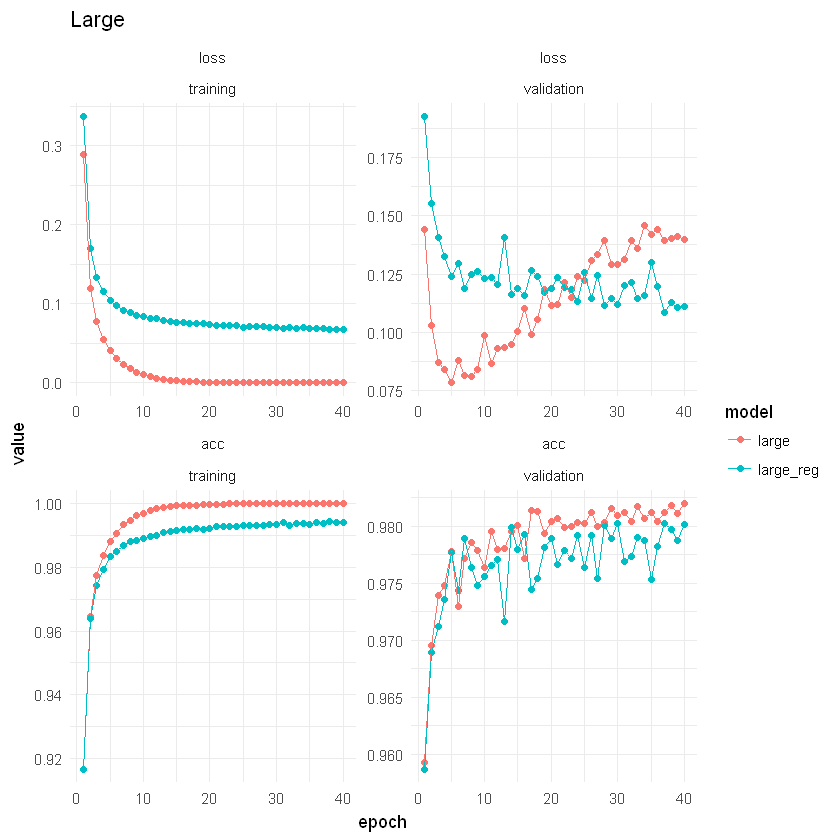

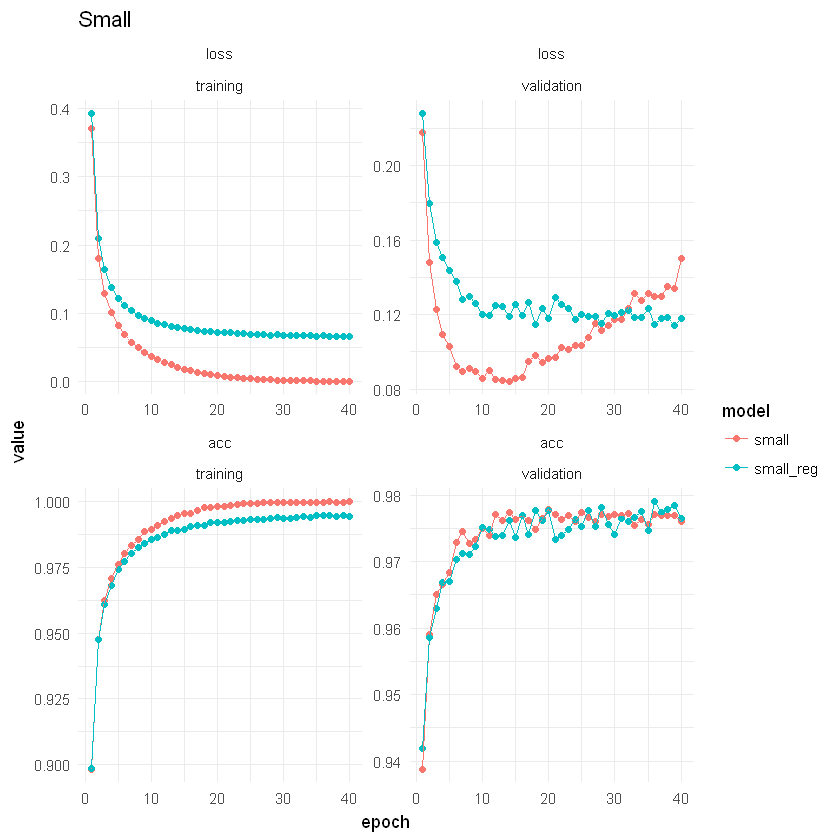

In [6]:
history_small_regularized = history_small_regularized %>% as_data_frame %>% mutate(model = 'small_reg')
history_large_regularized = history_large_regularized  %>% as_data_frame %>% mutate(model = 'large_reg')

history_bind_large_regularized = bind_rows(history_large, history_large_regularized)

history_bind_large_regularized %>% ggplot(aes(x = epoch, y = value, group = model, colour = model)) +
    geom_point() +
    geom_line() +
    facet_wrap(scales = 'free', ~metric+data, ncol = 2) + theme_minimal() + ggtitle('Large')

history_bind_small_regularized = bind_rows(history_small, history_small_regularized)

history_bind_small_regularized %>% ggplot(aes(x = epoch, y = value, group = model, colour = model)) +
    geom_point() +
    geom_line() +
    facet_wrap(scales = 'free', ~metric+data, ncol = 2) + theme_minimal() + ggtitle('Small')

### Adding dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Geoff Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly dropping out (setting to zero) a number of output features of the layer during training. Let’s say a given layer would normally return a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training. After applying dropout, this vector will have a few zero entries distributed at random: for example, [0, 0.5, 1.3, 0, 1.1].

The dropout rate is the fraction of the feature that are zeroued out. It is usually set between 0.2 and 0.5. At test time, no units are dropped out; instead, the layer;s output values are scaled down by a dactor equal to the dropout rate, to balance for the fact that more units are acrive at a training time.

In [7]:
(model_large_dropout = keras_model_sequential() %>% 
            layer_dense(units = 512, activation = "relu",
                        input_shape = c(28 * 28), use_bias = T, name='first_layer') %>%
            layer_dropout(rate = 0.5) %>%
            layer_dense(units = 10, activation = "softmax",
                        use_bias = T, name = 'output_layer'))

(model_small_dropout = keras_model_sequential() %>% 
            layer_dense(units = 128, activation = "relu",
                        input_shape = c(28 * 28), use_bias = T, name='first_layer') %>%
            layer_dropout(rate = 0.5) %>%
            layer_dense(units = 10, activation = "softmax",
                        use_bias = T, name = 'output_layer'))

model_large_dropout %>% compile(optimizer = "rmsprop",
                    loss = "categorical_crossentropy",
                    metrics = c("accuracy")
                    )

model_small_dropout %>% compile(optimizer = "rmsprop",
                    loss = "categorical_crossentropy",
                    metrics = c("accuracy")
                    )

model_large_dropout %>% fit(train_images,
                train_labels,
                epochs = 40,
                batch_size = 128,
                validation_split = 0.2
                ) -> history_large_dropout

model_small_dropout %>% fit(train_images,
                train_labels,
                epochs = 40,
                batch_size = 128,
                validation_split = 0.2
                ) -> history_small_dropout


model_large_dropout$save('data/model_large_dropout.h5')
model_large_dropout$save_weights('data/model_large_dropout_w.h5')
saveRDS(history_large_dropout, 'data/history_large_dropout.rds')

model_small_dropout$save('data/model_small_dropout.h5')
model_small_dropout$save_weights('data/model_small_dropout_w.h5')
saveRDS(history_small_dropout, 'data/history_small_dropout.rds')

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
first_layer (Dense)                 (None, 512)                     401920      
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 512)                     0           
________________________________________________________________________________
output_layer (Dense)                (None, 10)                      5130        
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
________________________________________________________________________________



Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
first_layer (Dense)                 (None, 128)                     100480      
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 128)                     0           
________________________________________________________________________________
output_layer (Dense)                (None, 10)                      1290        
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
________________________________________________________________________________



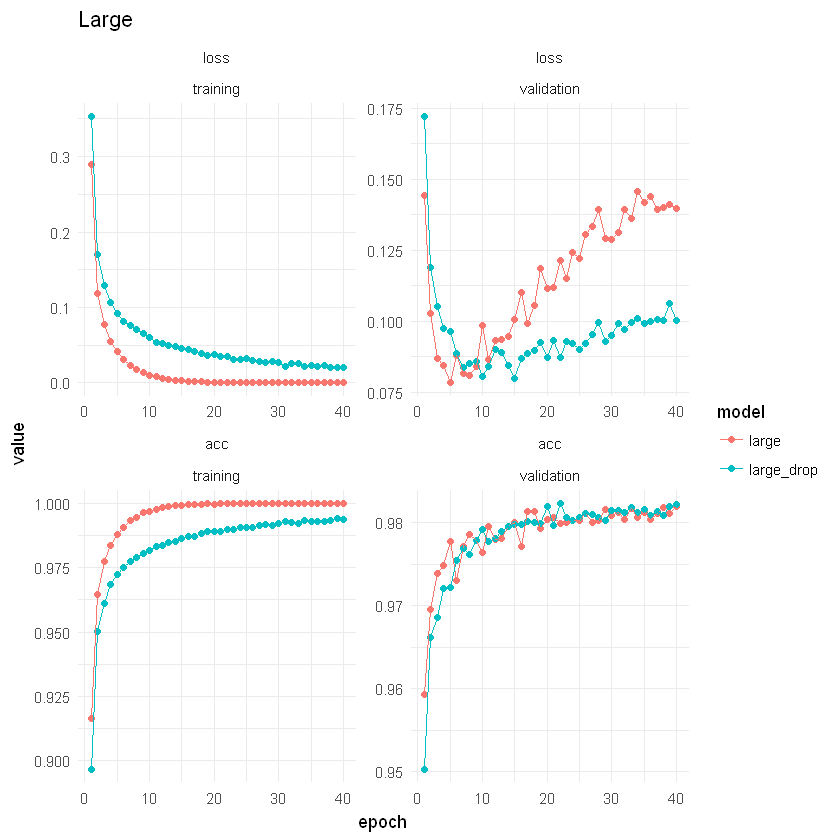

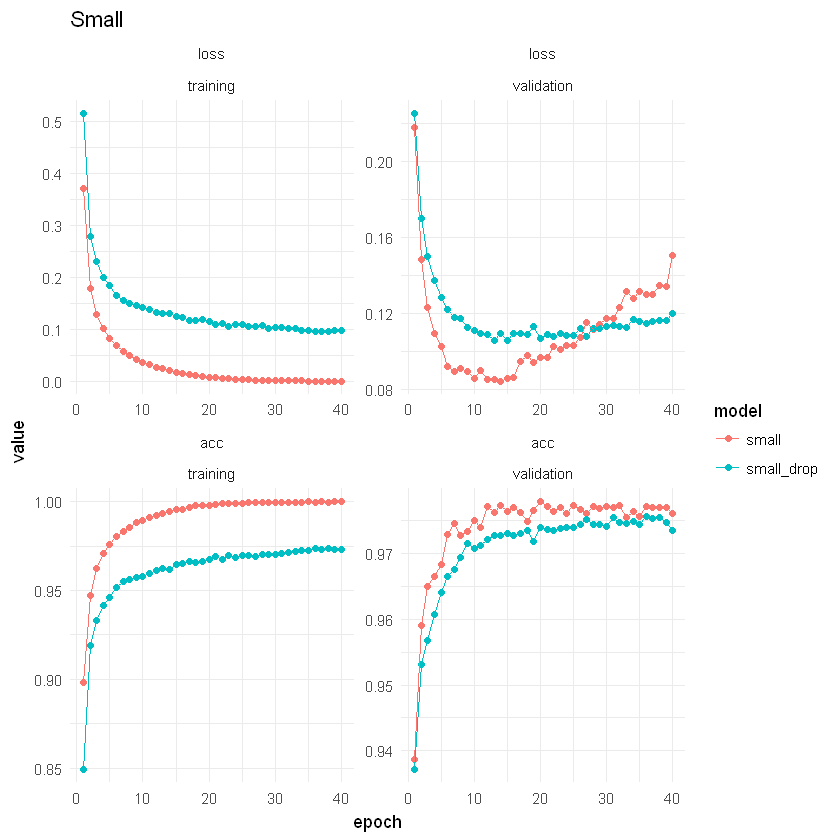

In [8]:
### code here

history_small_dropout = history_small_dropout %>% as_data_frame %>% mutate(model = 'small_drop')
history_large_dropout = history_large_dropout  %>% as_data_frame %>% mutate(model = 'large_drop')

history_bind_large_dropout = bind_rows(history_large, history_large_dropout)

history_bind_large_dropout %>% ggplot(aes(x = epoch, y = value, group = model, colour = model)) +
    geom_point() +
    geom_line() +
    facet_wrap(scales = 'free', ~metric+data, ncol = 2) + theme_minimal() + ggtitle('Large')

history_bind_small_dropout = bind_rows(history_small, history_small_dropout)

history_bind_small_dropout %>% ggplot(aes(x = epoch, y = value, group = model, colour = model)) +
    geom_point() +
    geom_line() +
    facet_wrap(scales = 'free', ~metric+data, ncol = 2) + theme_minimal() + ggtitle('Small')

### Scaling up: developing a model that overfits

To figure out how big a model you’ll need, you must develop a model that overfits. This is fairly easy:
- Add layers.
- Make the layers bigger.
- Train for more epochs.

Always monitor the training loss and validation loss, as well as the training and validation values for any metrics you care about. When you see that the model’s performance on the validation data begins to degrade, you’ve achieved overfitting. The next stage is to start regularizing and tuning the model, to get as close as possible to the ideal model that neither underfits nor overfits.

###  Regularizing your model and tuning your hyperparameters
This step will take the most time: you’ll repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. These are some things you should try:
- Add dropout.
- Try different architectures: add or remove layers.
- Add L1 and/or L2 regularization.
- Try different hyperparameters (such as the number of units per layer or the learning rate of the optimizer) to find the optimal configuration.
- Optionally, iterate on feature engineering: add new features, or remove features that don’t seem to be informative.

Be mindful of the following: every time you use feedback from your validation process to tune your model, you leak information about the validation process into the model. Repeated just a few times, this is innocuous; but done systematically over many iterations, it will eventually cause your model to overfit to the validation process (even though no model is directly trained on any of the validation data). This makes the evaluation process less reliable, so keep it in mind.
Once you’ve developed a good enough model configuration, you can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set. If it turns out that performance on the test set is significantly worse than the performance measured on the validation data, this may mean either that your validation procedure wasn’t reliable after all, or that you started overfitting to the validation data while tuning the parameters of the model. In this case, you may want to switch to a more reliable evaluation protocol (such as iterated K-fold validation).